In [7]:
import pandas as pd
import numpy as np
import math, time
import tensorflow
import cv2
from keras.models import load_model
from time import time
from datetime import datetime
from PIL import Image
from IPython.display import display, HTML
from tqdm import tqdm
import itertools as it
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from scipy.stats import mode
import warnings 
warnings.filterwarnings("ignore")


filename="ITMD 525_03.MOV"   #filename
cap = cv2.VideoCapture(filename) #Read Frame
fps=cap.get(cv2.CAP_PROP_FPS) #Extract the frame per second (fps) 
print('Frames per second : ', fps,'FPS')
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)#get overall no# of frames in the video file
print('Frame count : ', frame_count)
sessions=pd.read_excel('session_info.xlsx', sheet_name='Sheet2')
sessions=sessions.rename(columns=lambda x:x.strip())
ses_crop=sessions.iloc[:, 0:7] #cropping the session info table for columns of interest 
display(HTML(ses_crop.to_html()))

#selecting only sessions for which we have homework values 
ses_crop=ses_crop[np.isnan(ses_crop['# of students with wrong answers'])==False]
ses_crop.reset_index(drop=True, inplace=True)
display(HTML(ses_crop.to_html()))

Frames per second :  29.97002997002997 FPS
Frame count :  93268.0


,File Name,Start time,End time,session_name,# of students in video,which assignments,# of students with wrong answers
0,ITMD 525_03.MOV,6.25,9.00,Information Overload & Solutions for Information Overload,13,NaN,NaN
1,ITMD 525_03.MOV,9.22,10.09,Chunking,13,NaN,NaN
2,ITMD 525_03.MOV,10.10,10.29,Omission,13,NaN,NaN
3,ITMD 525_03.MOV,10.30,10.51,Queuing,13,NaN,NaN
4,ITMD 525_03.MOV,10.52,11.17,Capitulation,16,NaN,NaN
5,ITMD 525_03.MOV,11.40,12.19,Filtering & Giving examples about who uses RecSys,16,NaN,NaN
6,ITMD 525_03.MOV,16.20,19.45,RecSys,17,NaN,NaN
7,ITMD 525_03.MOV,19.46,22.14,How RecSys works (Netflix Example),18,NaN,NaN
8,ITMD 525_03.MOV,22.15,24.20,How it works,18,NaN,NaN
9,ITMD 525_03.MOV,24.22,28.07,Traditional Recommendation Algs,18,NaN,NaN


,File Name,Start time,End time,session_name,# of students in video,which assignments,# of students with wrong answers
0,ITMD 525_03.MOV,36.50,40.29,Rating Prediction,18,hw6,8.0
1,ITMD 525_03.MOV,40.29,46.13,Top-N Recommendation,18,hw 6,3.0
2,ITMD 525_03.MOV,47.26,51.52,Relevance Metrics,18,"hw2, hw6",3.0


In [8]:
#let's convert the start time and end time columns into proper time format i.e "%H:%M:%S"
import math, time
starttime=[]
for i in range(len(ses_crop)):
    starttime.append(math.modf(ses_crop['Start time'][i])) # (0.5678000000000338, 1234.0)
print('\nstart time in disected form:', starttime)
    
seconds_s=[round(x[0]*100) for x in starttime]
secondsfromminutes_s=[x[1]*60 for x in starttime]

total_seconds_s=[]
for i in range(len(seconds_s)):
    total_seconds_s.append(seconds_s[i]+secondsfromminutes_s[i])
Start_time=[]
for i in range(len(total_seconds_s)):
    Start_time.append(time.strftime("%H:%M:%S", time.gmtime(total_seconds_s[i])))
print('\n\nStart time in Time Format:',Start_time)

#doing the same for End time
endtime=[]
for i in range(len(ses_crop)):
    endtime.append(math.modf(ses_crop['End time'][i])) # (0.5678000000000338, 1234.0)
print('\nEnd time in disected form:',endtime)

seconds_e=[round(x[0]*100) for x in endtime]
secondsfromminutes_e=[x[1]*60 for x in endtime]

total_seconds_e=[]
for i in range(len(seconds_e)):
    total_seconds_e.append(seconds_e[i]+secondsfromminutes_e[i])
End_time=[]
for i in range(len(total_seconds_e)):
    End_time.append(time.strftime("%H:%M:%S", time.gmtime(total_seconds_e[i])))
print('\n\nEnd time in Time Format:',End_time)

ses_len=[]
for i in range(len(total_seconds_s)):
    ses_len.append(total_seconds_e[i]-total_seconds_s[i])


start time in disected form: [(0.5, 36.0), (0.28999999999999915, 40.0), (0.259999999999998, 47.0)]


Start time in Time Format: ['00:36:50', '00:40:29', '00:47:26']

End time in disected form: [(0.28999999999999915, 40.0), (0.13000000000000256, 46.0), (0.5200000000000031, 51.0)]


End time in Time Format: ['00:40:29', '00:46:13', '00:51:52']


In [9]:
#assigning the time values in correct format to cropped session dataframe
ses_crop['Start time']=Start_time
ses_crop['End time']=End_time
display(HTML(ses_crop.to_html()))

#slicing session-wise attendance for comparison at later stage
num_students=ses_crop.iloc[:,3:5]
display(HTML(num_students.to_html()))


,File Name,Start time,End time,session_name,# of students in video,which assignments,# of students with wrong answers
0,ITMD 525_03.MOV,00:36:50,00:40:29,Rating Prediction,18,hw6,8.0
1,ITMD 525_03.MOV,00:40:29,00:46:13,Top-N Recommendation,18,hw 6,3.0
2,ITMD 525_03.MOV,00:47:26,00:51:52,Relevance Metrics,18,"hw2, hw6",3.0


,session_name,# of students in video
0,Rating Prediction,18
1,Top-N Recommendation,18
2,Relevance Metrics,18


In [10]:
#for each session we have to divide the video into 3 slices begin, dom, end
#for each of sub-sessions, we have to determine start frame and end frame for slicing the sessions
#let's determine startframe and endframe for begin session
startframe_begin=[]
for i in range(len(total_seconds_s)):
    startframe_begin.append(fps*(total_seconds_s[i]))

#after 5 seconds, begin subsession ends, therefore end frame of the begin subsession is located at (total_seconds_ofstarttime+5 seconds)*fps
endframe_begin=[]
for i in range(len(total_seconds_s)):
    endframe_begin.append(fps*(total_seconds_s[i]+5))

#endframe_begin = startframe_dom
#endframe_dom = startframe_end

#startframe_end & endframe_end can be calculated with by using total_seconds_e
startframe_end=[]
for i in range(len(total_seconds_e)):
    startframe_end.append(fps*(total_seconds_e[i]-5))
    
endframe_end=[]
for i in range(len(total_seconds_e)):
    endframe_end.append(fps*total_seconds_e[i])

my_dict={'session_name':ses_crop['session_name'],'startframe_begin':startframe_begin, 'endframe_begin':endframe_begin,'startframe_end':startframe_end,'endframe_end':endframe_end, 'session_length':ses_len}
ses_timeframes=pd.DataFrame(my_dict)


#reseting the index so that loop iteration does not face any probelms
ses_timeframes.reset_index(drop=True, inplace=True)
display(HTML(ses_timeframes.to_html()))

,session_name,startframe_begin,endframe_begin,startframe_end,endframe_end,session_length
0,Rating Prediction,66233.766234,66383.616384,72647.352647,72797.202797,219.0
1,Top-N Recommendation,72797.202797,72947.052947,82957.042957,83106.893107,344.0
2,Relevance Metrics,85294.705295,85444.555445,93116.883117,93266.733267,266.0


In [11]:
#let's now break down the video files into sessions as given in excel file
#further each session is going to be further divided into sub-sessions: begin, dom, end

tic=time.time()

#initializing lists for storing session-wise values for each subsession
begin_list = []
dom_list = []
end_list =[]
useless=[]
c =0

#setting height and width of the frame to be stored for face recognition
height=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) #height
width=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) #width

for i in tqdm(range(int(frame_count))):
    #following if-elif statements are only meants for determining value of c for iterating through the ses_timeframes table shown above
    
    if 66233.766234  <= i <= 72797.202797:
        c=0
    elif 72797.202797  <= i <= 83106.893107:
        c=1
    elif 85294.705295  <= i <= 93266.733267:
        c=2
  
       
    #read the frame from given video file
    ret, frame = cap.read()
    
    frame=cv2.resize(frame, (width,height))  #resize the frame
    
    if i>=ses_timeframes['startframe_begin'][c] and i<=ses_timeframes['endframe_begin'][c]:  
        begin_list.append([ses_timeframes['session_name'][c],frame])            #output
    elif i>=ses_timeframes['endframe_begin'][c] and i<=ses_timeframes['startframe_end'][c]:
        dom_list.append([ses_timeframes['session_name'][c],frame]) 
    elif i>=ses_timeframes['startframe_end'][c] and i<=ses_timeframes['endframe_end'][c]:  
        end_list.append([ses_timeframes['session_name'][c],frame]) 
   # else:
    #    useless.append(frame)
        
#creating data frames out of lists
df_begin = pd.DataFrame(begin_list, columns=["session_name", "frame"])
df_dom = pd.DataFrame(dom_list, columns=["session_name", "frame"])
df_end = pd.DataFrame(end_list, columns=["session_name", "frame"]) 

#printing heads for begin, dom and end dfs
print('Begin Sessions Number of Frames', len(df_begin),  df_begin.head())
print('\n\nDOM Sessions Number of Frames', len(df_dom), df_dom.head())
print('\n\nEnd Sessions Number of Frames', len(df_end), df_end.head())  

tac=time.time()
print('Execution Time: ',round(tac-tic),' sec')


100%|██████████████████████████████████████████████████████████████████████████| 93268/93268 [00:50<00:00, 1835.70it/s]


Begin Sessions Number of Frames 450         session_name                                              frame
0  Rating Prediction  [[[72, 133, 147], [72, 133, 147], [72, 133, 14...
1  Rating Prediction  [[[72, 133, 147], [72, 133, 147], [72, 133, 14...
2  Rating Prediction  [[[73, 134, 148], [73, 134, 148], [73, 134, 14...
3  Rating Prediction  [[[71, 134, 148], [71, 134, 148], [71, 134, 14...
4  Rating Prediction  [[[73, 134, 148], [73, 134, 148], [73, 134, 14...


DOM Sessions Number of Frames 23946         session_name                                              frame
0  Rating Prediction  [[[77, 139, 151], [77, 139, 151], [77, 139, 15...
1  Rating Prediction  [[[76, 138, 150], [76, 138, 150], [76, 138, 15...
2  Rating Prediction  [[[76, 138, 150], [76, 138, 150], [76, 138, 15...
3  Rating Prediction  [[[76, 138, 150], [76, 138, 150], [76, 138, 15...
4  Rating Prediction  [[[74, 138, 150], [74, 138, 150], [74, 138, 15...


End Sessions Number of Frames 449         session_name      

In [12]:
#just checking the number of frames per subsession 
begin_sessions=df_begin.groupby(['session_name'], sort=False).count()
display(HTML(begin_sessions.to_html()))
dom_sessions=df_dom.groupby(['session_name'],sort=False).count()
display(HTML(dom_sessions.to_html()))
end_sessions=df_end.groupby(['session_name'],sort=False).count()
display(HTML(end_sessions.to_html()))

,frame
session_name,
Rating Prediction,150
Top-N Recommendation,150
Relevance Metrics,150


,frame
session_name,
Rating Prediction,6264
Top-N Recommendation,10010
Relevance Metrics,7672


,frame
session_name,
Rating Prediction,150
Top-N Recommendation,149
Relevance Metrics,150


In [13]:
#function for applying HaarCascade algorithm on every
def Prob_Emo_Haar (image):
    #changing color model for the input image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces using the classifier
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    probs=[]
    # Loop over detected faces
    for (x, y, w, h) in faces:
        # Extract the face region of interest (ROI)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]

        # Resize the face ROI to the input size of the emotion recognition model
        roi_resized = cv2.resize(roi_gray, (64, 64), interpolation=cv2.INTER_AREA)
        roi_resized = roi_resized.astype("float") / 255.0
        roi_resized = np.expand_dims(roi_resized, axis=0)

        # Make a forward pass through the emotion recognition model
        preds = emotion_model.predict(roi_resized)
        probs.append(preds)
        
    return probs

    

In [14]:
import cv2
import numpy as np
import itertools as it
from keras.models import load_model

tic = time.time()

# Load pre-trained classifiers
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
emotion_model = load_model('emotion_model.hdf5')

# Define class labels for emotions
EMOTIONS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

#detect number of faces for each frame of begin subsessions
face_list_begin=[]
for i in tqdm(range(int(len(df_begin)))):
    frame_1=df_begin['frame'][i]
    prob_emo=Prob_Emo_Haar(frame_1)
    face_list_begin[len(face_list_begin):]=[(df_begin['session_name'][i], prob_emo)]
    
faces_begin = pd.DataFrame(face_list_begin, columns=["session_name", "Prob of Emotions"])  

#detect number of faces for each frame of begin subsessions
face_list_dom=[]
for i in tqdm(it.chain(range(0, 910), range(977, 7141), range(7210, 14511), range(14568, 15293), range(15414, 19962), range(19968, 21719),range(21743, 23946))):
    frame_1=df_dom['frame'][i]
    prob_emo=Prob_Emo_Haar(frame_1)
    face_list_dom[len(face_list_dom):]=[(df_dom['session_name'][i], prob_emo)]
    
faces_dom = pd.DataFrame(face_list_dom, columns=["session_name", "Prob of Emotions"])  

#detect number of faces for each frame of begin subsessions
face_list_end=[]
for i in tqdm(range(int(len(df_end)))):
    frame_1=df_end['frame'][i]
    prob_emo=Prob_Emo_Haar(frame_1)
    face_list_end[len(face_list_end):]=[(df_end['session_name'][i], prob_emo)]
    
faces_end = pd.DataFrame(face_list_end, columns=["session_name", "Prob of Emotions"])  


tac=time.time()
print('Execution Time: ',round(tac-tic),' sec')

100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [00:43<00:00, 10.39it/s]
23602it [19:56, 19.73it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 449/449 [00:27<00:00, 16.52it/s]

Execution Time:  1269  sec


,session_name,emotion,avg_emotion,std_dev_emotion
0,Rating Prediction,angry,"[[0.27968186, 0.0013620872, 0.06897759, 0.21569255, 0.19899543, 0.0033970543, 0.23189346]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]"
1,Rating Prediction,angry,"[[0.2506021, 0.0037983067, 0.19334759, 0.20818034, 0.1749027, 0.012327851, 0.15684116]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]"
2,Rating Prediction,neutral,"[[0.21844721, 0.014668617, 0.113043025, 0.10130901, 0.31278834, 0.0058733965, 0.23387042]]","[[0.10578819, 0.013145457, 0.006097261, 0.08103088, 0.17072944, 0.0022920347, 0.0008610487]]"
3,Rating Prediction,surprise,"[[0.2481459, 0.03153845, 0.10311427, 0.1000541, 0.24953642, 0.00645346, 0.26115736]]","[[0.070187435, 0.028749108, 0.02408003, 0.06262989, 0.12778789, 0.004816279, 0.0051766634]]"
4,Rating Prediction,surprise,"[[0.22547854, 0.0024976109, 0.15642662, 0.1738988, 0.19829692, 0.013215327, 0.2301862]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]"


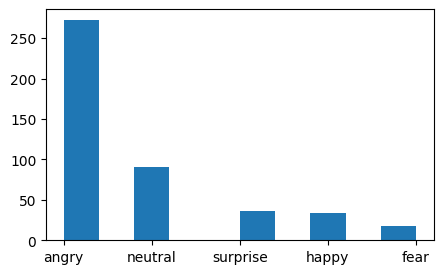

session_name
Rating Prediction       neutral
Relevance Metrics         angry
Top-N Recommendation      angry
Name: emotion, dtype: object

In [17]:
#let's analyze which emotion is dominant for each session
#there are two ways to do this
#number#1: For a given frame, get average of all of probability ndarrays of emotion. Subsequently, assign a label for 
#emotion for each frame on the basis of maximum value of emotion. This method is implemented in this code cell.
avg_emotion_b=[]
std_emotion_b=[]
emo_b=[]
for i in range(len(faces_begin)):
    list_b=faces_begin.iloc[i,1]
    avg_emo = np.mean(list_b, axis=0)   #getting average of arrays of emotions for every frame
    std_emo = np.std(list_b, axis=0)    #getting standard deviation of arrays of emotions for every frame
    maxindex = int(np.argmax(avg_emo))
    emotion = EMOTIONS[maxindex]  #figuring out the emotion label based on highest value of emotion
    emo_b.append(emotion)               #preparing list of emotion label  
    avg_emotion_b.append(avg_emo)       #preparing list of ndarrays of average emotion
    std_emotion_b.append(std_emo)       #preparing list of ndarrays of standard deviation of emotion for a frame
    

faces_begin['emotion']= emo_b
faces_begin['avg_emotion']=avg_emotion_b #per frame
faces_begin['std_dev_emotion']= std_emotion_b
begin_emotion_framewise=faces_begin.drop(columns='Prob of Emotions')
display(HTML(begin_emotion_framewise.head().to_html()))

# Creating histogram
fig, ax = plt.subplots(figsize =(5,3))
ax.hist(emo_b )
 
# Show plot
plt.show()

#finally let's get value of mode of emotion for each session
begin_emotion_framewise.groupby(['session_name'])['emotion'].agg(pd.Series.mode)


In [18]:
#let's try another way now
#number#2:In this, we'll get ALL the emotion arrays for a given session
#In other words, we'll be aggregating emotion arrayss for each of the frames of a given session
#Then we'll find the average of emotion arrays for that session

#let's generate list of lists of emotion ndarryas since each frame contains a list of emotion ndarryas
# so aggregation will result in list of lists

df1=faces_begin.groupby(['session_name'])['Prob of Emotions'].agg(pd.Series)


rating_predict=df1.iloc[0]

#Let's disintegrate the list of lists such that it's only a list containing all emotion values of for given session
flat_list_1 = []
for sublist in rating_predict:
    for item in sublist:
        flat_list_1.append(item)
        
session_avg1=np.mean(flat_list_1, axis=0)
maxindex = int(np.argmax(session_avg1))
emo_ses_avg1 = EMOTIONS[maxindex] 
        
print("\n\nTotal number of Emotions Detected in Begin Session of Rating Prediction: ", len(flat_list_1))
print("Avg emotion for Begin session of Rating Prediction: ", emo_ses_avg1 )

#let's try the same thing for another session
relevance_met=df1.iloc[1]

#Let's disintegrate the list of lists such that it's only a list containing all emotion values of for given session
flat_list_2 = []
for sublist in relevance_met:
    for item in sublist:
        flat_list_2.append(item)
        
session_avg2=np.mean(flat_list_2, axis=0)
maxindex = int(np.argmax(session_avg2))
emo_ses_avg2 = EMOTIONS[maxindex] 
        
print("\nTotal number of Emotions Detected in Begin Session of Relevance Metrics: ", len(flat_list_2))
print("Avg emotion for Begin session of Rating Prediction: ", emo_ses_avg2 )

#let's try the same thing for Top-N Recommendation session 
top_recom=df1.iloc[2]

#Let's disintegrate the list of lists such that it's only a list containing all emotion values of for given session
flat_list_3 = []
for sublist in top_recom:
    for item in sublist:
        flat_list_3.append(item)

session_avg3=np.mean(flat_list_3, axis=0)
maxindex = int(np.argmax(session_avg3))
emo_ses_avg3 = EMOTIONS[maxindex] 
        
print("\nTotal number of Emotions Detected in Begin Session of Top-N Recommendation: ", len(flat_list_3))
print("Avg emotion for Begin session of Rating Prediction: ", emo_ses_avg3 )




Total number of Emotions Detected in Begin Session of Rating Prediction:  202
Avg emotion for Begin session of Rating Prediction:  neutral

Total number of Emotions Detected in Begin Session of Relevance Metrics:  219
Avg emotion for Begin session of Rating Prediction:  angry

Total number of Emotions Detected in Begin Session of Top-N Recommendation:  219
Avg emotion for Begin session of Rating Prediction:  angry


In [ ]:
#let's analyze which emotion is dominant for each session
#there are two ways to do this
#number#1: For a given frame, get average of all of probability ndarrays of emotion. Subsequently, assign a label for 
#emotion for each frame on the basis of maximum value of emotion. This method is implemented in this code cell.

avg_emotion_d=[]
std_emotion_d=[]
emo_d=[]
for i in range(len(faces_dom)):
    list_d=faces_dom.iloc[i,1]
    avg_emo = np.mean(list_d, axis=0)   #getting average of arrays of emotions for every frame
    std_emo = np.std(list_d, axis=0)    #getting standard deviation of arrays of emotions for every frame
    maxindex = int(np.argmax(avg_emo))
    emotion = EMOTIONS[maxindex]  #figuring out the emotion label based on highest value of emotion
    emo_d.append(emotion)               #preparing list of emotion label  
    avg_emotion_d.append(avg_emo)       #preparing list of ndarrays of average emotion
    std_emotion_d.append(std_emo)       ##preparing list of ndarrays of standard deviation of emotion for a frame
    
#updating the dataframe
faces_dom['emotion']= emo_d
faces_dom['avg_emotion']=avg_emotion_d 
faces_dom['std_dev_emotion']= std_emotion_d
dom_emotion_framewise=faces_dom.drop(columns='Prob of Emotions')
display(HTML(dom_emotion_framewise.head().to_html()))

# Creating histogram
fig, ax = plt.subplots(figsize =(5,3))
ax.hist(emo_d )
 
# Show plot
plt.show()

#finally let's get value of mode of emotion for each session
dom_emotion_framewise.groupby(['session_name'])['emotion'].agg(pd.Series.mode)


In [19]:
#let's try another way now
#In this, we'll get ALL the emotion arrays for a given session
#In other words, we'll be aggregating emotion arrayss for each of the frames of a given session
#Then we'll find the average of emotion arrays for that session

#let's generate list of lists of emotion ndarryas since each frame contains a list of emotion ndarryas
# so aggregation will result in list of lists

df2=faces_dom.groupby(['session_name'])['Prob of Emotions'].agg(pd.Series)


rating_predict=df2.iloc[0]

#Let's disintegrate the list of lists such that it's only a list containing all emotion values of for given session
flat_list_4 = []
for sublist in rating_predict:
    for item in sublist:
        flat_list_4.append(item)
        
session_avg4=np.mean(flat_list_4, axis=0)
maxindex = int(np.argmax(session_avg4))
emo_ses_avg4 = EMOTIONS[maxindex] 
        
print("\n\nTotal number of Emotions Detected in Begin Session of Rating Prediction: ", len(flat_list_4))
print("Avg emotion for Begin session of Rating Prediction: ", emo_ses_avg4 )

#let's try the same thing for another session
relevance_met=df2.iloc[1]

#Let's disintegrate the list of lists such that it's only a list containing all emotion values of for given session
flat_list_5 = []
for sublist in relevance_met:
    for item in sublist:
        flat_list_5.append(item)
        
session_avg5=np.mean(flat_list_5, axis=0)
maxindex = int(np.argmax(session_avg5))
emo_ses_avg5 = EMOTIONS[maxindex] 
        
print("\nTotal number of Emotions Detected in Begin Session of Relevance Metrics: ", len(flat_list_5))
print("Avg emotion for Begin session of Rating Prediction: ", emo_ses_avg5 )

#let's try the same thing for Top-N Recommendation session 
top_recom=df2.iloc[2]

#Let's disintegrate the list of lists such that it's only a list containing all emotion values of for given session
flat_list_6 = []
for sublist in top_recom:
    for item in sublist:
        flat_list_6.append(item)

session_avg6=np.mean(flat_list_6, axis=0)
maxindex = int(np.argmax(session_avg6))
emo_ses_avg6 = EMOTIONS[maxindex] 
        
print("\nTotal number of Emotions Detected in Begin Session of Top-N Recommendation: ", len(flat_list_6))
print("Avg emotion for Begin session of Rating Prediction: ", emo_ses_avg6 )



Total number of Emotions Detected in Begin Session of Rating Prediction:  7696
Avg emotion for Begin session of Rating Prediction:  angry

Total number of Emotions Detected in Begin Session of Relevance Metrics:  5587
Avg emotion for Begin session of Rating Prediction:  angry

Total number of Emotions Detected in Begin Session of Top-N Recommendation:  10118
Avg emotion for Begin session of Rating Prediction:  angry


,session_name,emotion,avg_emotion,std_dev_emotion
0,Rating Prediction,happy,"[[0.26324973, 0.007950181, 0.018577881, 0.46575364, 0.09129773, 0.0027411832, 0.15042962]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]"
1,Rating Prediction,happy,"[[0.26621345, 0.019522524, 0.01888522, 0.36913702, 0.15191527, 0.0033514346, 0.1709751]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]"
2,Rating Prediction,happy,"[[0.22158796, 0.009826631, 0.029641258, 0.42953494, 0.14281768, 0.0027662148, 0.16382533]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]"
3,Rating Prediction,angry,"[[0.38343412, 0.0057445965, 0.08220005, 0.33299088, 0.09844533, 0.0029915366, 0.09419354]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]"
4,Rating Prediction,happy,"[[0.2644961, 0.0038251155, 0.109129615, 0.41193795, 0.09416519, 0.0018706094, 0.114575416]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]"


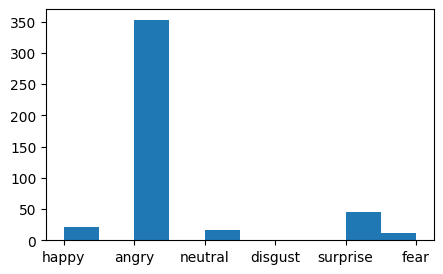

session_name
Rating Prediction       angry
Relevance Metrics       angry
Top-N Recommendation    angry
Name: emotion, dtype: object

In [20]:
avg_emotion_e=[]
std_emotion_e=[]
emo_e=[]
for i in range(len(faces_end)):
    list_e=faces_dom.iloc[i,1]
    avg_emo = np.mean(list_e, axis=0)   #getting average of arrays of emotions for every frame
    std_emo = np.std(list_e, axis=0)    #getting standard deviation of arrays of emotions for every frame
    maxindex = int(np.argmax(avg_emo))
    emotion = EMOTIONS[maxindex]  #figuring out the emotion label based on highest value of emotion
    emo_e.append(emotion)               #preparing list of emotion label  
    avg_emotion_e.append(avg_emo)       #preparing list of ndarrays of average emotion
    std_emotion_e.append(std_emo)       ##preparing list of ndarrays of standard deviation of emotion for a frame
    
#updating the dataframe
faces_end['emotion']= emo_e
faces_end['avg_emotion']=avg_emotion_e 
faces_end['std_dev_emotion']= std_emotion_e
end_emotion_framewise=faces_end.drop(columns='Prob of Emotions')
display(HTML(end_emotion_framewise.head().to_html()))

# Creating histogram
fig, ax = plt.subplots(figsize =(5,3))
ax.hist(emo_e )
 
# Show plot
plt.show()

#finally let's get value of mode of emotion for each session
end_emotion_framewise.groupby(['session_name'])['emotion'].agg(pd.Series.mode)


In [21]:
#let's try another way now
#In this, we'll get ALL the emotion values for a given session
#In other words, we'll be aggregating emotion values for each of the frames of a given session
#Then we'll find the mode of emotion values for that session

#let's generate list of lists of emotion since each frame contains a list of emotion
# so aggregation will result in list of lists

df3=faces_begin.groupby(['session_name'])['Prob of Emotions'].agg(pd.Series)

rating_predict=df3.iloc[0]

#Let's disintegrate the list of lists such that it's only a list containing all emotion values of for given session
flat_list_7 = []
for sublist in rating_predict:
    for item in sublist:
        flat_list_7.append(item)
        
session_avg7=np.mean(flat_list_7, axis=0)
maxindex = int(np.argmax(session_avg7))
emo_ses_avg7 = EMOTIONS[maxindex] 
        
print("\n\nTotal number of Emotions Detected in Begin Session of Rating Prediction: ", len(flat_list_7))
print("Avg emotion for Begin session of Rating Prediction: ", emo_ses_avg7 )

#let's try the same thing for another session
relevance_met=df3.iloc[1]

#Let's disintegrate the list of lists such that it's only a list containing all emotion values of for given session
flat_list_8 = []
for sublist in relevance_met:
    for item in sublist:
        flat_list_8.append(item)
        
session_avg8=np.mean(flat_list_8, axis=0)
maxindex = int(np.argmax(session_avg8))
emo_ses_avg8 = EMOTIONS[maxindex] 
        
print("\nTotal number of Emotions Detected in Begin Session of Relevance Metrics: ", len(flat_list_8))
print("Avg emotion for Begin session of Rating Prediction: ", emo_ses_avg8 )

#let's try the same thing for Top-N Recommendation session 
top_recom=df3.iloc[2]

#Let's disintegrate the list of lists such that it's only a list containing all emotion values of for given session
flat_list_9 = []
for sublist in top_recom:
    for item in sublist:
        flat_list_9.append(item)

session_avg9=np.mean(flat_list_9, axis=0)
maxindex = int(np.argmax(session_avg9))
emo_ses_avg9 = EMOTIONS[maxindex] 
        
print("\nTotal number of Emotions Detected in Begin Session of Top-N Recommendation: ", len(flat_list_9))
print("Avg emotion for Begin session of Rating Prediction: ", emo_ses_avg9 )



Total number of Emotions Detected in Begin Session of Rating Prediction:  202
Avg emotion for Begin session of Rating Prediction:  neutral

Total number of Emotions Detected in Begin Session of Relevance Metrics:  219
Avg emotion for Begin session of Rating Prediction:  angry

Total number of Emotions Detected in Begin Session of Top-N Recommendation:  219
Avg emotion for Begin session of Rating Prediction:  angry
